In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from IPython.display import clear_output
import wandb

import numpy as np
import pylab as pl

from src import *

import sys
sys.setrecursionlimit(2000)

/Users/francescosacco/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = {
    'image':'lizard_red.png',
    'growing_file':'Pretrained_models/lizard/persist.pt',
    'virus_file':'Pretrained_models/lizard/persist.pt',

    'target_size':40,
    'target_padding':8,
    'n_channels':15,
    'original_channel':-2,
    'virus_channel':-1,

    'pool_size': 2**5,
    'generator_iters_min':64,
    'generator_iters_max':96,
    'virus_rate':0.02,
    'square_side':3,

    'start_appling_loss':64,
    'start_appling_kill_loss':64,
    'kill_multiplier':1e-3,
    'perturbation_multiplier':1e-6,

    'lr':2e-3,
    'batch_size':3,
    'weight_decay':0.1,
    'n_epochs':40,
    'n_max_loss_ratio':16,
    'evolution_iters':80,
    'kind':'persist',
    'skip_update':1,
    'skip_damage':1,
    'reset_prob':0,

    'step_size':20,
    'gamma':0.1,

    'trained_model_name': 'bug_to_butterfly'
    }

config["n_max_losses"] = max(1, config["batch_size"] // config["n_max_loss_ratio"])
config["image_size"] = config["target_size"] + config["target_padding"]

In [3]:
wandb.init(mode="disabled")
#wandb.init(project="Virus color", entity="neural_ca", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [4]:
torch.backends.cudnn.benchmark = True # Speeds up things

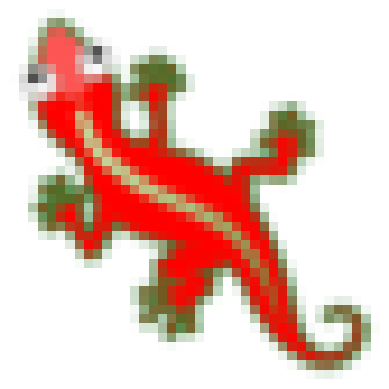

In [5]:
# Imports the target emoji
target = read_image("images/" + config["image"], ImageReadMode.RGB_ALPHA).float()
target = RGBAtoFloat(target)
target = T.ToPILImage()(target)
target = T.Resize((config["target_size"], config["target_size"]), interpolation=T.InterpolationMode.BILINEAR)(target)
target = T.ToTensor()(target)

imshow(target)

In [6]:
# Define the model
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device

device = torch.device(device)
print(f'using "{device}" for processing')
target = target.to(device)

model = MultipleCA(config["n_channels"], n_CAs=2, device=device)

using "mps" for processing


In [7]:
model.CAs[0].load(config["growing_file"])
model.CAs[1].load(config["growing_file"])

#MakeLora(model.CAs[1],4)

Successfully loaded model!
Successfully loaded model!


In [8]:
for param in model.CAs[0].parameters():
    param.requires_grad = False

generator = VirusGenerator(config["n_channels"], config["original_channel"], config["virus_channel"], config["image_size"], 2, model,
                           iter_func=ExponentialSampler(min=config["generator_iters_min"], max=config["generator_iters_max"]),
                           virus_func=RandomVirus(config["virus_rate"]))
pool = SamplePool(config["pool_size"], generator)

In [9]:
losses = [NCALoss(pad(target, config["target_padding"]), alpha_channels=[-1, -2]),
          OldCellLoss()]
weights = [ConstantWeight(config["start_appling_loss"]),
           ConstantWeight(config["start_appling_kill_loss"], constant=config["kill_multiplier"])]

criterion = CombinedLoss(losses, weights)

#model.end_step_loss = NCADistance(model.CAs[1], starting_weights, config["perturbation_multiplier"])

In [10]:
params = model.CAs[1].parameters()

for param in model.CAs[1].parameters():
    print(param.shape, param.requires_grad)



optimizer = torch.optim.Adam(params, lr=config["lr"], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config["step_size"], config["gamma"])

#model.train_CA(optimizer, criterion, pool, scheduler=scheduler, **config)

torch.Size([128, 48, 1, 1]) True
torch.Size([128]) True
torch.Size([16, 128, 1, 1]) True
torch.Size([16]) True


In [11]:
#model.CAs[1].layers[0].factor_matrix1
for param in model.CAs[1].parameters():
    print(param.shape, param.requires_grad)


torch.Size([128, 48, 1, 1]) True
torch.Size([128]) True
torch.Size([16, 128, 1, 1]) True
torch.Size([16]) True


In [12]:
kind = "persist" #@param ["growing", "persist", "regenerating"]
epochs = 120#@param {type:"integer"}

losses = []
model.train()

image="lizard_red"
for epoch in range(epochs):
    for j in range(pool.size // config["batch_size"]):
        inputs, indexes = pool.sample(config["batch_size"]) # sample the inputs
        inputs = inputs.to(model.device) # put them in the current device
        optimizer.zero_grad() # reinitialize the gradient to zero

        # recursive forward-pass
        evolutions_per_image = pool.get_evolutions_per_image(indexes)
        inputs, total_losses = model.loss_eval(inputs, criterion, config["evolution_iters"], evolutions_per_image, epoch)

        # Remove the worst performers, often times they degenerate and ruin everything
        total_loss = torch.mean(total_losses[total_losses < 5*total_losses.mean()])
        total_loss.backward()
        optimizer.step()

        # customization of training for the three processes of growing, persist and regenerating
        # if regenerating, then damage inputs
        if kind == "regenerating" and j % config["skip_damage"] == 0:
            inputs = inputs.detach()
            # damages the inputs by removing square portions
            inputs = make_squares(inputs)

        # Skips the replacement of the images with maximum loss
        if j % config["skip_update"] != 0:
            idx_max_loss = None

        # if training is not for growing re-insert the images into the pool
        if kind != "growing":
            idx_max_loss = n_largest_indexes(total_losses, config["n_max_losses"])
            pool.update(indexes, inputs, idx_max_loss, config["evolution_iters"])

        losses.append(total_loss.detach().cpu().item())

    # Reset the pool at epoch 20 and 60 
    # Resetting the pool is like kicking the tv
    if epoch in [20, 60]:
        pool.reset()
        
    # Update the scheduler
    scheduler.step()
    
    # Display loss and pool samples
    clear_output(wait=True)
    pl.title("Loss vs Training steps")
    pl.plot(losses, '.', alpha=0.3)
    pl.yscale("log")
    pl.show()

    pl.figure(figsize = (16,4))
    imshow(state_to_image(inputs[:4].detach().cpu(), [-1, -2]))

    #model.CAs[1].save(f"./checkpoints/{image}_epoch_{epoch}.pt", overwrite=True)

    print(f"epoch: {epoch}, loss: {losses[-1]:.4f}", flush=True)
    #print(f"cos(CA_1, CA_2): {ruler.cosine_similarity(*model.CAs):.3f}, ||CA_1 - CA_2||: {ruler.distance(*model.CAs):.3f}", flush=True)
    print(f"cos(CA_1, CA_2): {ruler.cosine_similarity(*model.CAs):.3f}, ||CA_1 - CA_2||: {ruler.distance(*model.CAs):.3f}", flush=True)

/Users/francescosacco/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 48, 48])) that is different to the input size (torch.Size([3, 4, 48, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

# Video

In [ ]:
import moviepy.editor as mvp

square_side =  2#@param {type:"integer"}
#@markdown Percentage of virus cells for the random virus
virus_rate = 0.1 #@param {type:"number"}

#@markdown SquareVirus: the virus starts in a single square.

#@markdown RandomVirus: the virus starts in a spray pattern with a virus_rate
#@markdown percentage of virus cells
virus = RandomVirus(virus_rate) #@param ["SquareVirus(square_side)", "RandomVirus(virus_rate)"] {type:"raw"}

number_of_steps = 240 #@param {type:"integer"}
fps = 30 #@param {type:"integer"}

#@markdown You can add damage to the NCA
damage = False #@param {type:"boolean"}

#@markdown For colorblind users, hue_factor shifts the hue of the evolution video(left).
#@markdown The value must be between -0.5 and 0.5
hue_factor = 0.#@param {type:"number"}

#@markdown Left: evolution video, Right: cell mask, with orange being the original
#@markdown cells and blue the virus/adversarial cells

# The seed is a square dot in the middle of the grid
seed = make_seed(1, config["n_channels"], config["image_size"], n_CAs=2,
                 alpha_channel=config["original_channel"], device=device)

# First evolve the seed only with the original NCA for 64 steps
converter = [tensor_to_RGB(function="RGBA", CA=model),
             tensor_to_RGB(function=[-2,-1], CA=model)]
             
video, init_state = make_video(model, 64, seed,
                               converter=converter, fps=fps)
# Then add the virus
init_state = virus.add_virus(init_state, config["original_channel"],
                             config["virus_channel"])

# And evolve for number_of_steps the original and the virus together
video = make_video(model, number_of_steps, init_state, initial_video=video,
                   converter=converter, fps=fps, regenerating=damage)

# Shift hue of the evolution video
evolution, mask = video[0]
if np.abs(hue_factor) > 1e-4:
  for i in range(0, number_of_steps + 64, 64):
    evolution[i:i+64] = adjust_hue(evolution[i:i+64] / 255, hue_factor) * 255

# Concat evolution and mask
video = torch.cat([evolution, mask], dim=3)

# Display video
write_video("_.mp4", video.permute(0, 2, 3, 1), fps=fps)
mvp.ipython_display("_.mp4")

In [ ]:
ruler.cosine_similarity(*model.CAs), ruler.distance(*model.CAs)

(tensor(0.6596, device='cuda:0'), tensor(0.1713, device='cuda:0'))

In [ ]:
model.CAs[1].save(config["trained_model_name"] + ".pt", overwrite=True)

wandb.save(config["trained_model_name"] + ".pt")

Successfully saved model!


['/home/lettera/Desktop/neural_cellular_automata/pytorch_ca/wandb/run-20220131_114914-m9sqh0n4/files/bug_to_butterfly.pt']

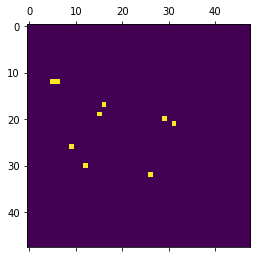

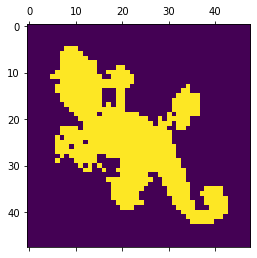

In [ ]:
pl.matshow(image[0, -1].cpu()>0.1)
pl.matshow(image[0, -2].cpu()>0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


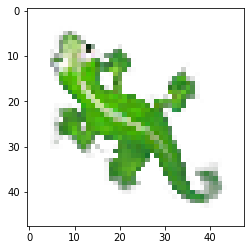

In [ ]:
image = pool.sample(1)[0].detach().cuda()

imshow(state_to_image(image, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


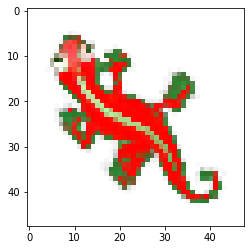

In [ ]:
image = model.evolve(image, 20)

imshow(state_to_image(image, [-1, -2])[0])

In [ ]:
# Log pool samples
imgs = []

for i in range(16):
    img = pool.sample(1)[0].detach().cpu()
    img = state_to_image(img, [-1, -2])[0]
    img = np.asarray(img.permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

In [ ]:
# Lizard grow to persist
model.CAs[0].load("Pretrained_models/lizard/Virus/lizard_growing_until_160.pt")
model.CAs[1].load("Pretrained_models/lizard/Virus/lizard_grow_to_persist_squareside_4.pt")

Successfully loaded model!
Successfully loaded model!


In [ ]:
# Buttefly grow to persist
model.CAs[0].load("Pretrained_models/butterfly/dying_butterfly.pt")
model.CAs[1].load("Pretrained_models/butterfly/Virus/growing_to_persist.pt")

Successfully loaded model!
Successfully loaded model!


In [ ]:
# Firework grow to persist
model.CAs[0].load("Pretrained_models/firework/Virus/firework_growing_64_96.pt")
model.CAs[1].load("Pretrained_models/firework/Virus/firework_virus_ckp_50%.pt")

Successfully loaded model!
Successfully loaded model!


In [ ]:
# Lizard green red
model.CAs[0].load("Pretrained_models/lizard/lizard_persist.pt")
model.CAs[1].load("Pretrained_models/lizard/Virus/lizard_persist_green_to_red_squareside_3.pt")

Successfully loaded model!
Successfully loaded model!


In [ ]:
# Lizard no tail
model.CAs[0].load("Pretrained_models/lizard/lizard_persist.pt")
model.CAs[1].load("Pretrained_models/lizard/Virus/lizard_persist_to_no_tail.pt")

Successfully loaded model!
Successfully loaded model!


In [ ]:
# Bug to butterfly
model.CAs[0].load("Pretrained_models/bug/bug_persist.pt")
model.CAs[1].load("Pretrained_models/bug/Virus/bug_to_butterfly_google_12.pt")

Successfully loaded model!
Successfully loaded model!


In [ ]:
add_virus = RandomVirus(0.01).add_virus

In [ ]:
converter=[tensor_to_RGB(function="RGBA",CA=model),
           tensor_to_RGB(function=[-2,-1],CA=model)]

seed=make_seed(1,config["n_channels"],config["image_size"],n_CAs=2,alpha_channel=config["original_channel"],device=device)
video,init_state=make_video(model,60,seed,converter=converter)
init_state=add_virus(init_state,-2,-1)
out, _=make_video(model,500,init_state,initial_video=video,converter=converter, regenerating=False)

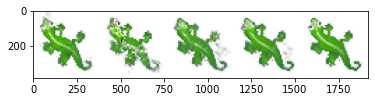

In [ ]:
name = "lizard_grow_to_persist_1percent"
write_video(name+".mp4", torch.cat(out, dim=3).permute(0, 2, 3, 1), fps=15)

def plot_evolution(evolution, time_steps, fname):
    images = evolution.permute(0,2,3,1)[time_steps]/255

    images = rearrange(images, 'b h w c -> h (b w) c')

    pl.imshow(images)
    save_image(images.permute(2, 0, 1), fname)

slice = [60, 100, 150, 200, 500]
plot_evolution(out[1], slice, name + "_alpha.png")
plot_evolution(out[0], slice, name + ".png")

In [ ]:
for name in ["virus_alpha.mp4", "virus.mp4"]:
    wandb.log({name: wandb.Video(name, fps=10)})